## 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50.データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1.ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．  
2.情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．  
3.抽出された事例をランダムに並び替える．  
4.抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．  
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．  

In [1]:
import sklearn
print(sklearn.__version__)

0.22.1


In [2]:
"""
データを抽出するシェル

newsCorpora.csvから抽出
形式はtab区切りcsv（jsonがよかったな...）
txtファイルにするから、json形式に変えてもダメ
"""

import csv
path_q50 = "data_folder/NewsAggregatorDataset/newsCorpora.csv"
extracted_data_q50 = "data_folder/extracted_data_q50.txt"
publisher_set = {"Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"}


with open(path_q50,"r") as csv_f, open(extracted_data_q50,"w") as ed:
    reader = csv.reader(csv_f, delimiter='\t', quotechar='|')
    
    for data in reader:
        publisher = data[3]
        if publisher in publisher_set:
            ed.write("\t".join(data))
            ed.write("\n")

In [3]:
"""
データをシャッフル
"""
import random

with open(extracted_data_q50,"r") as ed:
    lines = ed.readlines()
with open(extracted_data_q50,"w") as ed:
    random.shuffle(lines)
    ed.writelines(lines)

In [4]:
num_of_article = sum([1 for _ in open(extracted_data_q50)])

train_data_num = num_of_article * 0.8
valid_data_num = (num_of_article - train_data_num) / 2
test_data_num = num_of_article - train_data_num - valid_data_num 

train_data = "data_folder/train.txt"
valid_data = "data_folder/valid.txt"
test_data = "data_folder/test.txt"


c = 0
with open(extracted_data_q50,"r") as extracted, open(train_data,"w") as train, open(valid_data,"w") as valid, open(test_data,"w") as test:
    for l in extracted:
        l = l.strip().split("\t")
        title = l[1]
        category = l[4]
        c += 1
        if c <= train_data_num:
            train.write(f"{title}\t{category}\n")
        elif c <= train_data_num + valid_data_num:
            valid.write(f"{title}\t{category}\n")
        else:
            test.write(f"{title}\t{category}\n")

In [5]:
!wc -l data_folder/train.txt
!wc -l data_folder/valid.txt
!wc -l data_folder/test.txt

!wc -l data_folder/extracted_data_q50.txt

   10683 data_folder/train.txt
    1335 data_folder/valid.txt
    1336 data_folder/test.txt
   13354 data_folder/extracted_data_q50.txt


## 51.特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [1]:
"""
4値分類を行うタスク？
"""

from sklearn.feature_extraction.text import CountVectorizer as CV
import numpy as np
cv = CV()

def extract_feature(file_name):
    with open(f"data_folder/{file_name}.txt","r") as f, open(f"data_folder/{file_name}.feature.txt","wb") as nf:
        data_set = dict()
        category_id = {"b":0, "t":1, "e":2, "m":3}
        
        for l in f:
            t, c = l.strip().split("\t")
            data_set[t] = c
        
        if file_name == "train":
            matrix = cv.fit_transform([t for t in data_set.keys()])
        else:
            matrix = cv.transform([t for t in data_set.keys()])

        X, Y = matrix.toarray(), np.array([category_id[c] for c in data_set.values()])
        
        for x, y in zip(X, Y):
            nf.write(x)
            nf.write(y)
        
        return(X, Y)
                
        # np.savetxt(f"data_folder/{file_name}.feature.txt", vectors, fmt='%d')         

In [3]:
extract_feature("train")
extract_feature("valid")
extract_feature("test")

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([1, 0, 0, ..., 1, 0, 2]))

## 52.学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [7]:
from sklearn.linear_model import LogisticRegression as lr

lr = lr(max_iter=1000)
x, y = extract_feature("train")

lr.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 53.予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．  
CATEGORY	News category (b = business, t = science and technology, e = entertainment, m = health)

In [8]:
def calc_probably(title):
    x = cv.transform([title])
    probs = lr.predict_proba(x)
    categorys = ["b", "t", "e", "m"]
    [print(f'{c}:{p}') for c, p in zip(categorys, probs[0])]

In [9]:
from itertools import islice
with open("data_folder/test.txt",'r') as f:
    for l in islice(f, 3):
        print(l.strip())
        calc_probably(l.split("\t")[0])
        print("\n")

UPDATE 2-AT&T threatens to sit out US spectrum auction over rules	t
b:0.7770806159028842
t:0.13163470647758352
e:0.05366992074956809
m:0.03761475686996433


UPDATE 3-Tiffany's US sales on the mend; shares rise	b
b:0.9782261548315666
t:0.014732968480285167
e:0.001266310396541325
m:0.005774566291606837


French April Industry Growth Cools as New Business Stagnates (1)	b
b:0.9491364970817003
t:0.014190299636892716
e:0.029558356823153924
m:0.007114846458253132




In [10]:
from itertools import islice
with open("data_folder/test.txt",'r') as f:
    calc_probably("More PS5 preorders coming tomorrow to GameStop, and here's the latest at Amazon, Walmart and more")

b:0.2716520169727647
t:0.4663248915066168
e:0.2287686018778001
m:0.033254489642818366


## 54.正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．



In [11]:
def predict_category(title):
    x = cv.transform([title])
    probs = lr.predict_proba(x)
    categorys = ["b", "t", "e", "m"]
    m = max(probs[0])
    for c, p in zip(categorys, probs[0]):
        if p == m:
            return c

In [12]:
from sklearn.metrics import accuracy_score

def calc_accuracy(file):
    with open(f"data_folder/{file}.txt",'r') as f:
        true, pred = [], []
        for l in f:
            true.append(l.strip().split('\t')[1])
            pred.append(predict_category(l.strip().split('\t')[0]))
        return accuracy_score(pred, true)

In [13]:
print(calc_accuracy("train"))
print(calc_accuracy("test"))

0.995974913413835
0.9116766467065869


## 55.混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

#colum : actural  
#row : predicted  
CATEGORY	News category (b = business, t = science and technology, e = entertainment, m = health)

In [14]:
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(file):
    with open(f"data_folder/{file}.txt",'r') as f:
        true, pred = [], []
        for l in f:
            true.append(l.strip().split('\t')[1])
            pred.append(predict_category(l.strip().split('\t')[0]))
        return confusion_matrix(pred, true, labels=["b", "t", "e", "m"])

In [15]:
print(make_confusion_matrix("train"))
print(make_confusion_matrix("valid"))

[[4464   17    9    1]
 [   6 1201    2    0]
 [   2    3 4253    3]
 [   0    0    0  722]]
[[554  29   7   9]
 [ 12  97   5   3]
 [  6  16 503  18]
 [  3   5   1  67]]


## 56.適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [16]:
from sklearn.metrics import precision_recall_fscore_support

def calc_f_value(file, option):
    with open(f"data_folder/{file}.txt",'r') as f:
        categorys = ["b", "t", "e", "m"]
        true, pred = [], []
        
        for l in f:
            true.append(l.strip().split('\t')[1])
            pred.append(predict_category(l.strip().split('\t')[0]))
            
        return precision_recall_fscore_support(true, pred, labels=categorys, average=option)

In [17]:
result = calc_f_value("test", None)
print(f"b    prec: {result[0][0]}    rec: {result[1][0]}    f1: {result[2][0]}")
print(f"t    prec: {result[0][1]}    rec: {result[1][1]}    f1: {result[2][1]}")
print(f"e    prec: {result[0][2]}    rec: {result[1][2]}    f1: {result[2][2]}")
print(f"m    prec: {result[0][3]}    rec: {result[1][3]}    f1: {result[2][3]}")


print("\naverage")
print(f'micro: {calc_f_value("test", "micro")}')
print(f'macro: {calc_f_value("test", "macro")}')

b    prec: 0.9095394736842105    rec: 0.9567474048442907    f1: 0.9325463743676222
t    prec: 0.8442622950819673    rec: 0.6560509554140127    f1: 0.7383512544802868
e    prec: 0.9305816135084428    rec: 0.9649805447470817    f1: 0.9474689589302769
m    prec: 0.9041095890410958    rec: 0.7586206896551724    f1: 0.825

average
micro: (0.9116766467065869, 0.9116766467065869, 0.9116766467065868, None)
macro: (0.8971232428289291, 0.8340998986651393, 0.8608416469445466, None)


## 57.特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [20]:
from pprint import pprint

def get_best_or_worst_features(best_or_worst):
    weights = lr.coef_
    features = cv.get_feature_names()
    categorys = ["b", "t", "e", "m"]
    
    for i, c in enumerate(categorys):
        wf_pair = [(w, f) for w, f in zip(weights[i], features)]
        ranking = sorted(wf_pair, key=lambda x:x[0])
        
        if best_or_worst == "best":
            print(c)
            [print(r) for r in reversed(ranking[-10:])]
            print("\n")
            
        if best_or_worst == "worst":
            print(c)
            [print(r) for r in ranking[:10]]
            print("\n")

In [21]:
get_best_or_worst_features("best")

b
(1.8746410082809208, 'bank')
(1.7961003097925088, 'ecb')
(1.7313046376851688, 'fed')
(1.6572009321680883, 'stocks')
(1.6442806377196206, 'obamacare')
(1.5573501799682985, 'ukraine')
(1.536571259680325, 'yellen')
(1.529259119062467, 'china')
(1.4848733178174953, 'euro')
(1.4010448161596663, 'dollar')


t
(2.8056700575768136, 'facebook')
(2.710236709824856, 'google')
(2.539618609828477, 'microsoft')
(2.525588354528297, 'apple')
(2.40670433280452, 'climate')
(1.9421206874207093, 'heartbleed')
(1.8799166086561494, 'nasa')
(1.8286498905532218, 'tesla')
(1.7431059114947507, 'comcast')
(1.700374600480986, 'gm')


e
(1.5904919456140407, 'kardashian')
(1.5357333017469201, 'chris')
(1.4895298046536956, 'transformers')
(1.4299567035322442, 'movie')
(1.4055317619950132, 'paul')
(1.3786743442938936, 'miley')
(1.368023843593528, 'film')
(1.3268600623164044, 'cyrus')
(1.274096070978467, 'hbo')
(1.2573620370044414, 'beyonce')


m
(2.725336913931499, 'ebola')
(2.091368150830368, 'cancer')
(2.06894313

In [22]:
get_best_or_worst_features("worst")

b
(-1.4557497191930702, 'activision')
(-1.290992320204382, 'aereo')
(-1.2377860257669318, 'cap')
(-1.1864920301208217, 'ebola')
(-1.0900942887178058, 'she')
(-1.0847419943457026, 'nintendo')
(-1.0679346981975397, 'her')
(-1.0611870181188725, 'heartbleed')
(-1.0176762792099079, 'twitch')
(-0.989416465703285, 'recalled')


t
(-0.9529491506091431, 'stocks')
(-0.8794641606804162, 'american')
(-0.8605299502722263, 'percent')
(-0.80699965441831, 'valued')
(-0.7535802940375237, 'fed')
(-0.7246605274076605, 'raise')
(-0.7193364776354314, 'cancer')
(-0.6971030828520942, 'still')
(-0.6911249083267755, 'grows')
(-0.6801946251946063, 'ecb')


e
(-1.5605944482442298, 'google')
(-1.249366844545817, 'gm')
(-1.23192926779379, 'facebook')
(-1.2170634366010478, 'study')
(-1.1897524276040863, 'climate')
(-1.1824887193953861, 'apple')
(-1.1607286783895994, 'billion')
(-1.151392184562202, 'ceo')
(-1.147944322943662, 'china')
(-1.114763763574922, 'microsoft')


m
(-0.8102640037122457, 'dimon')
(-0.801946164

### 58.正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ

In [14]:
params = np.arange(0.25, 3.25, 0.25)
print(params)

[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.  ]


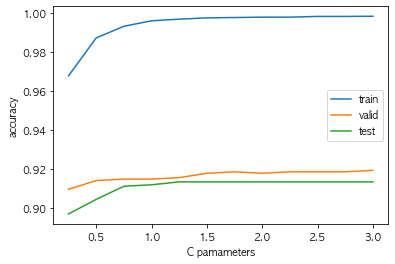

In [4]:
from sklearn.linear_model import LogisticRegression as lr
import matplotlib.pyplot as plt

plt.xlabel('C pamameters')
plt.ylabel('accuracy')
files = ["train", "valid", "test"]
params = np.arange(0.25, 3.25, 0.25)
x, y = extract_feature("train")

for file in files:
    accuracys = []
    for param in params:
        trained_model = lr(max_iter=1000, C=param).fit(x, y)
        accuracy = calc_accuracy(file, trained_model)
        accuracys.append(accuracy)
    
    plt.plot(params, accuracys, label=file)
plt.legend()

### 59.ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [3]:
from sklearn.metrics import accuracy_score
x, y = extract_feature("train")

def predict_category(title, model):
    category_id = {0:"b", 1:"t", 2:"e", 3:"m"}

    x = cv.transform([title])
    category = category_id[model.predict(x)[0]]
    return category

        
def calc_accuracy(file, model):
    with open(f"data_folder/{file}.txt",'r') as f:
        true, pred = [], []
        for l in f:
            true.append(l.strip().split('\t')[1])
            pred.append(predict_category(l.strip().split('\t')[0], model))
        return accuracy_score(pred, true)

In [14]:
# サポートベクターマシン
from sklearn.svm import LinearSVC

svc = LinearSVC().fit(x, y)
print(calc_accuracy("valid", svc))

0.9213483146067416


In [16]:
# SGD
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier().fit(x, y)
print(calc_accuracy("valid", sgdc))

0.9198501872659176


In [17]:
# tree
from sklearn import tree

dtc = tree.DecisionTreeClassifier().fit(x, y)
print(calc_accuracy("valid", dtc))

0.8119850187265918


In [26]:
# neural net
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier().fit(x, y)
print(calc_accuracy("valid", mlp))

0.9250936329588015


In [15]:
import matplotlib.pyplot as plt

def draw_graph(model, file):
    plt.xlabel('C pamameters')
    plt.ylabel('accuracy')
    params = np.arange(0.25, 3.25, 0.25)

    accuracys = []
    for param in params:
        x, y = extract_feature("train")
        trained_model = model(C=param).fit(x, y)
        accuracy = calc_accuracy(file, trained_model)
        accuracys.append(accuracy)
    
    plt.plot(params, accuracys, label=file)
    plt.legend()

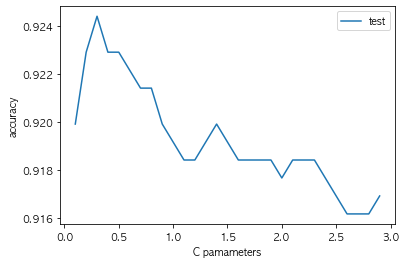

In [50]:
draw_graph(LinearSVC, "test")